In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

warnings.filterwarnings("ignore")

ex_dataset = '/kaggle/input/mai-ml-lab-1-fiit-2025/ex.csv'
train_dataset = '/kaggle/input/mai-ml-lab-1-fiit-2025/train.csv'
test_dataset = '/kaggle/input/mai-ml-lab-1-fiit-2025/test.csv'

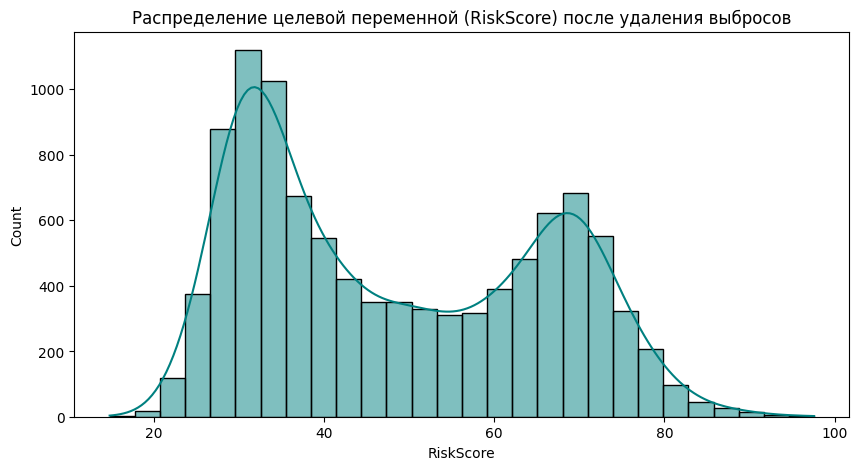

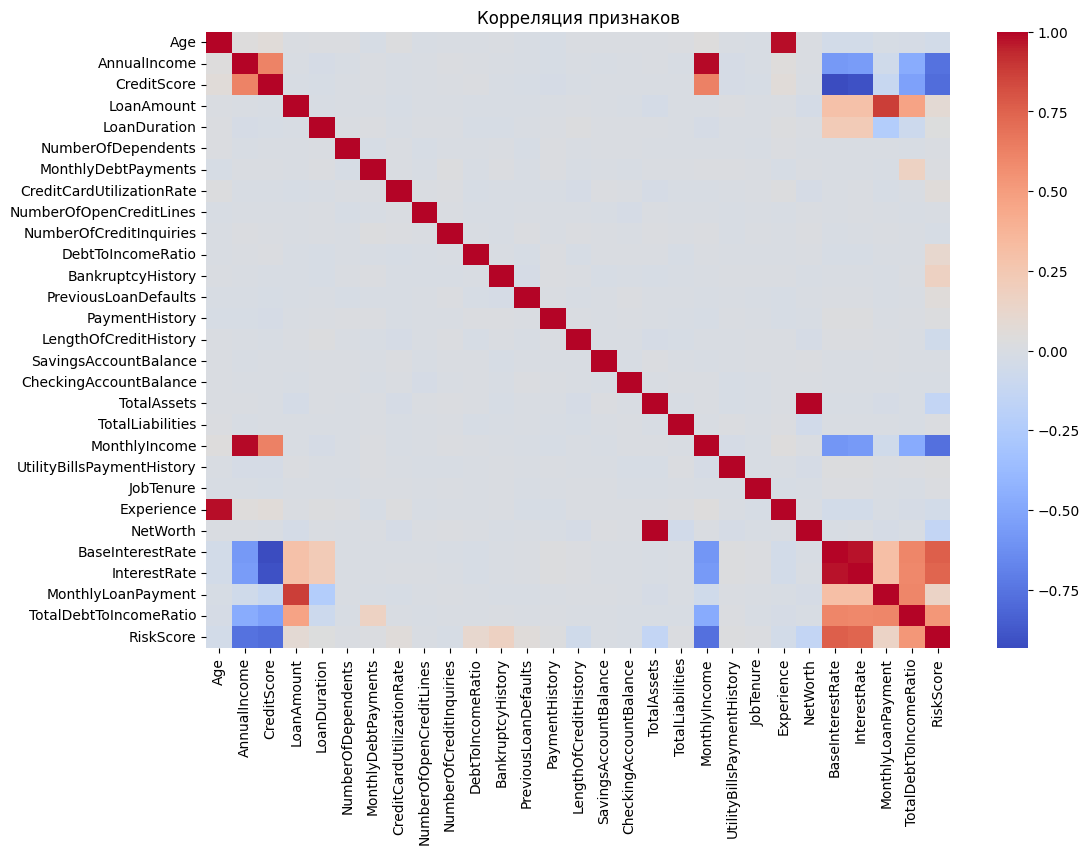

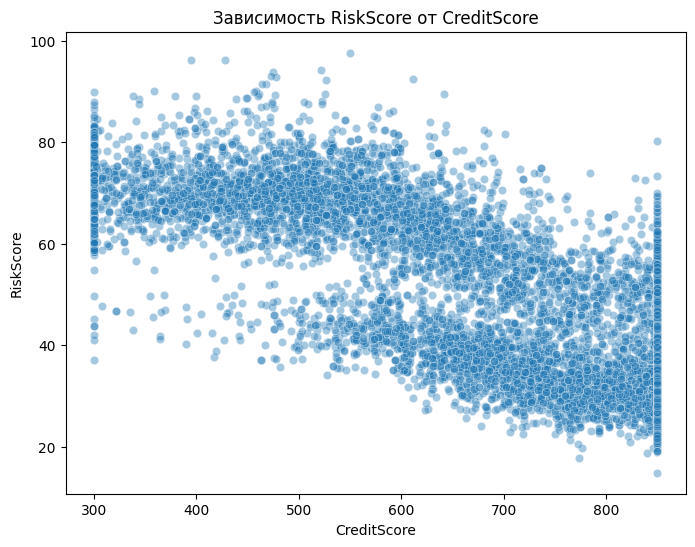

In [ ]:
train_df  = pd.read_csv(train_dataset)
test_df  = pd.read_csv(test_dataset)

train_df = train_df[(train_df['RiskScore'] > 0) & (train_df['RiskScore'] < 1000)].dropna(subset=['RiskScore'])

plt.figure(figsize=(10, 5))
sns.histplot(train_df['RiskScore'], kde=True, color='teal')
plt.title('Распределение целевой переменной (RiskScore) после удаления выбросов')
plt.show()

numeric_df = train_df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), cmap='coolwarm', annot=False)
plt.title('Корреляция признаков')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_df, x='CreditScore', y='RiskScore', alpha=0.4)
plt.title('Зависимость RiskScore от CreditScore')
plt.show()

In [ ]:
class CustomScaler:
    def z_score(self, data):
        return (data - data.mean()) / (data.std() + 1e-8)
    
    def min_max(self, data):
        return (data - data.min()) / (data.max() - data.min() + 1e-8)

def custom_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def custom_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def custom_r2(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))

def custom_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

In [ ]:
class MyLinearRegression:
    def __init__(self, method='analytic', lr=0.001, epochs=1000, 
                 reg_type=None, lambda_reg=0.1, p=2):
        self.method = method
        self.lr = lr
        self.epochs = epochs
        self.reg_type = reg_type 
        self.lambda_reg = lambda_reg
        self.p = p 
        self.w = None

    def _add_bias(self, X):
        return np.column_stack([np.ones(X.shape[0]), X])

    def _get_reg_grad(self, w):
        if self.reg_type == 'L1':
            return self.lambda_reg * np.sign(w)
        elif self.reg_type == 'L2':
            return self.lambda_reg * 2 * w
        elif self.reg_type == 'Elastic':
            return self.lambda_reg * (np.sign(w) + 2 * w)
        elif self.reg_type == 'Lp':
            return self.lambda_reg * self.p * (np.abs(w)**(self.p-1)) * np.sign(w)
        return 0

    def fit(self, X, y):
        X = self._add_bias(X)
        n_features = X.shape[1]
        
        if self.method == 'analytic':
            I = np.eye(n_features)
            I[0, 0] = 0 
            self.w = np.linalg.inv(X.T @ X + (self.lambda_reg + 1e-6) * I) @ X.T @ y
            
        elif self.method in ['gd', 'sgd']:
            self.w = np.zeros(n_features)
            for _ in range(self.epochs):
                if self.method == 'gd':
                    y_pred = X @ self.w
                    grad = (2/len(X)) * (X.T @ (y_pred - y)) + self._get_reg_grad(self.w)
                    self.w -= self.lr * grad
                else: 
                    idx = np.random.randint(len(X))
                    xi = X[idx:idx+1]
                    yi = y[idx:idx+1]
                    grad = 2 * (xi.T @ (xi @ self.w - yi)) + self._get_reg_grad(self.w)
                    self.w -= self.lr * grad

    def predict(self, X):
        X = self._add_bias(X)
        return X @ self.w

In [ ]:
def run_kfold(X, y, k=5):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    folds = np.array_split(indices, k)
    scores = []
    for i in range(k):
        val_idx = folds[i]
        train_idx = np.hstack([folds[j] for j in range(k) if j != i])
        
        model = MyLinearRegression(method='analytic', lambda_reg=0.1)
        model.fit(X[train_idx], y[train_idx])
        preds = model.predict(X[val_idx])
        scores.append(custom_mse(y[val_idx], preds))
    return np.mean(scores)

In [ ]:
def prepare_data(df, is_train=True):
    df = df.copy()
    
    if 'ApplicationDate' in df.columns:
        dt = pd.to_datetime(df['ApplicationDate'], errors='coerce')
        df['App_Year'] = dt.dt.year.fillna(2024)
        df['App_Month'] = dt.dt.month.fillna(6)
        df = df.drop(['ApplicationDate'], axis=1)
    if 'ID' in df.columns:
        df = df.drop(['ID'], axis=1)

    if 'InterestRate' in df and 'BaseInterestRate' in df:
        df['Rate_Spread'] = df['InterestRate'] - df['BaseInterestRate']

   
    main_cols = [
        'CreditScore', 'AnnualIncome', 'DebtToIncomeRatio', 'InterestRate', 
        'LoanAmount', 'MonthlyLoanPayment', 'TotalAssets', 'CreditCardUtilizationRate',
        'PaymentHistory', 'Experience', 'JobTenure', 'SavingsAccountBalance', 
        'TotalLiabilities', 'Rate_Spread'
    ]
    main_cols = [c for c in main_cols if c in df.columns]

    for c in main_cols:
        df[c] = df[c].fillna(df[c].median())

    for i in range(len(main_cols)):
        for j in range(i + 1, len(main_cols)):
            c1, c2 = main_cols[i], main_cols[j]
            df[f'v_{c1}_{c2}'] = df[c1] * df[c2]

    risk_flags = ['BankruptcyHistory', 'PreviousLoanDefaults']
    for flag in risk_flags:
        if flag in df.columns:
            df[flag] = df[flag].fillna(0)
            df[f'{flag}_x_DTI'] = df[flag] * df['DebtToIncomeRatio']
            df[f'{flag}_x_Score'] = df[flag] * df['CreditScore']

    eps = 1e-6
    top_5 = ['CreditScore', 'DebtToIncomeRatio', 'InterestRate', 'AnnualIncome', 'Rate_Spread']
    for col in [c for c in top_5 if c in df.columns]:
        df[f'{col}_Sq'] = df[col]**2
        df[f'{col}_log'] = np.log1p(df[col].clip(0))
        df[f'{col}_inv'] = 1.0 / (df[col] + eps)

    df["PayToIncRatio"] = df["MonthlyLoanPayment"] / (df["MonthlyIncome"] + eps)
    df["DebtToAssetsRatio"] = df["TotalLiabilities"] / (df["TotalAssets"] + eps)
    df['Stability'] = df['PaymentHistory'] * np.log1p(df['LengthOfCreditHistory'].clip(0) + 1)

    if 'CreditScore' in df:
        df['Credit_Tier'] = pd.cut(df['CreditScore'], bins=[0, 500, 600, 660, 720, 780, 850, 950], labels=False).astype(float)
    
    for col in df.columns:
        if col != "RiskScore":
            if df[col].dtype == 'object':
                df[col] = df[col].fillna(df[col].mode()[0])
            else:
                df[col] = df[col].fillna(df[col].median())
                
                low, high = df[col].quantile([0.01, 0.99])
                df[col] = df[col].clip(low, high)
            
    return pd.get_dummies(df, drop_first=True)

train_df = train_df[train_df["RiskScore"].between(1, 99)].dropna(subset=['RiskScore'])

X_train = prepare_data(train_df.drop('RiskScore', axis=1))
y_train = train_df['RiskScore'].values
X_test = prepare_data(test_df)

X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

scaler = CustomScaler()
X_train_scaled = scaler.z_score(X_train).values
X_test_scaled = scaler.z_score(X_test).values

final_model = MyLinearRegression(method='analytic', lambda_reg=0.005) 
final_model.fit(X_train_scaled, y_train)

train_preds = final_model.predict(X_train_scaled)
print(f"Итоговый MSE на трейне: {custom_mse(y_train, train_preds):.4f}")

Итоговый MSE на трейне: 27.7071


In [ ]:
from sklearn.linear_model import LinearRegression as SkLR
sk_model = SkLR()
sk_model.fit(X_train_scaled, y_train)
print("Sklearn MSE:", mean_squared_error(y_train, sk_model.predict(X_train_scaled)))

Sklearn MSE: 27.550661077183545
